# Following https://www.dzialowski.eu/football-data-visualisations/ on how to get data and https://github.com/mckayjohns/ for how to make visualisation in football.



In [1]:
import pandas as pd
import numpy as np
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import matplotlib.patches as mpatches
pd.set_option('display.max_columns', None)
from highlight_text import fig_text
#Set general use colors
text_color = 'w'

In [2]:
allgrizou=pd.DataFrame()
i=np.arange(1396,1401)


In [3]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r',encoding='utf8')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')
    for k in i:
        data_txt=data_txt.replace('\n</td></tr><tr><td class="line-number" value="'+ str(k) +'"></td><td class="line-content">',' ')
        data_txt=data_txt.replace('</td></tr><tr><td class="line-number" value="'+ str(k) + '"></td><td class="line-content"> ',' ')
        data_txt=data_txt.replace('\n</td></tr><tr><td class="line-number" value="'+str(k )+'"></td><td class="line-content"> ',' ')
    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [4]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [5]:
l=0
ass=[]
si=[]
def getAssist(df):
    for l in range(len(df)):
        if df.iloc[l]['isGoal']==True:
            c=df.iloc[l]['qualifiers']
            k=0
            for k in range(len(c)):
                if c[k]['type']['displayName']=='Assisted':
                    ass.append(df.iloc[l-1].id)
                    si.append(l-1)
        else:
            c=df.iloc[l]['qualifiers']
            k=0
            for k in range(len(c)):
                if c[k]['type']['displayName']=='IntentionalGoalAssist':
                    ass.append(df.iloc[l].id)
                    si.append(l)
    return ass,si



In [6]:
def get_passes_df(events_dict):
    a=[]
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df['isAssist']=False
    a,s=getAssist(df)
    df['isAssist']=df['id'].apply(lambda x: True if x in a else False)
        

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType","type","minute","isAssist"]]

    return df_passes

In [7]:
matches=['FraAus.html','FraDen.html','TunFra.html','FraPol.html','EngFra.html','FraMor.html','ArgFra.html']
event_list = ['SavedShot','MissedShots','Goal']
#match_html_path = 'ArgFra.html'
for m in matches:
    path='matches/'+ m
    json_data_txt = extract_json_from_html(path)
    #print(json_data_txt)
    data = json.loads(json_data_txt)
    events_dict, players_df, teams_dict = extract_data_from_dict(data)
    df = pd.DataFrame(events_dict)
    grizou=get_passes_df(events_dict)
    grizou=grizou[grizou['playerId']==80241]
    allgrizou=pd.concat([allgrizou,grizou])
allgrizou

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,type,minute,isAssist
16,2.487214e+09,56.4,1.9,71.5,17.6,341,80241.0,83249.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",0,False
88,2.487215e+09,36.1,5.2,19.9,2.6,341,80241.0,259648.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",4,False
209,2.487219e+09,45.5,41.2,44.0,64.8,341,80241.0,327721.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",13,False
211,2.487219e+09,56.5,65.7,87.8,93.2,341,80241.0,303115.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",13,False
214,2.487219e+09,62.7,98.1,51.4,87.8,341,80241.0,327721.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",13,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,2.492353e+09,42.3,36.7,39.4,68.0,341,80241.0,327721.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",66,False
1137,2.492353e+09,55.4,75.5,68.6,95.3,341,80241.0,303115.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",66,False
1139,2.492353e+09,67.1,89.3,78.3,95.7,341,80241.0,303115.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",66,False
1144,2.492353e+09,99.5,99.5,92.5,52.7,341,80241.0,333542.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",67,False


In [8]:
allgrizou[allgrizou['isAssist']==True]

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,type,minute,isAssist
1420,2.487851e+09,84.7,19.5,98.3,53.9,341,80241.0,300713.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",85,True
272,2.490217e+09,80.3,28.5,74.8,46.9,341,80241.0,353423.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",16,True
1247,2.490228e+09,79.7,98.1,94.2,51.3,341,80241.0,24444.0,Pass,Successful,"{'value': 1, 'displayName': 'Pass'}",77,True


findfont: Font family ['Andale Mono'] not found. Falling back to DejaVu Sans.


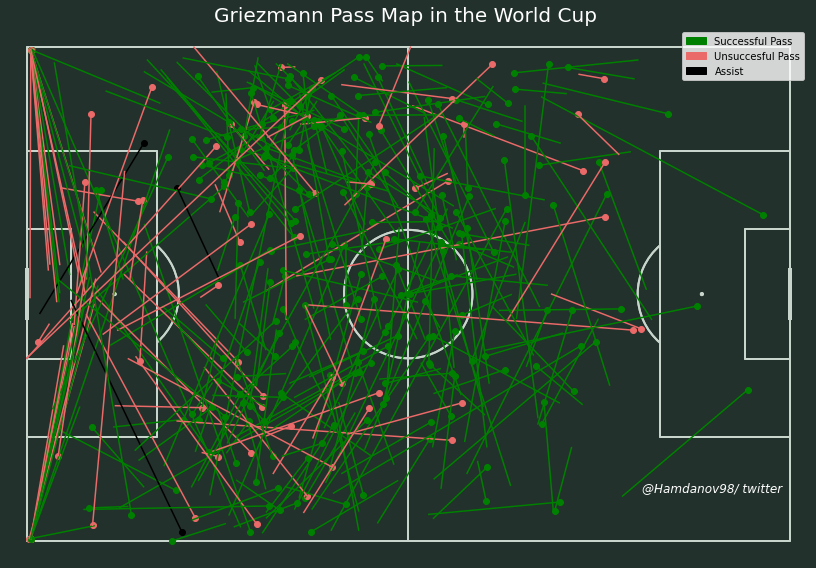

In [9]:
# Setup the pitch
pitch = Pitch(pitch_type='opta', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(13,8), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')
#Draw the pitch on the ax figure as well as invert the axis for this specific pitch
pitch.draw(ax=ax)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
i=0
for i in range(len(allgrizou)):
    if(allgrizou.iloc[i].isAssist==True):
        plt.plot((allgrizou.iloc[i]['x'],allgrizou.iloc[i]['endX']),(allgrizou.iloc[i]['y'],allgrizou.iloc[i]['endY']),color='black')
        plt.scatter(allgrizou.iloc[i]['x'],allgrizou.iloc[i]['y'],color='black')
    else:
        if(allgrizou.iloc[i].outcomeType=='Successful'):
            plt.plot((allgrizou.iloc[i]['x'],allgrizou.iloc[i]['endX']),(allgrizou.iloc[i]['y'],allgrizou.iloc[i]['endY']),color='green')
            plt.scatter(allgrizou.iloc[i]['x'],allgrizou.iloc[i]['y'],color='green')
        else:
            plt.plot((allgrizou.iloc[i]['x'],allgrizou.iloc[i]['endX']),(allgrizou.iloc[i]['y'],allgrizou.iloc[i]['endY']),color='#ea6969')
            plt.scatter(allgrizou.iloc[i]['x'],allgrizou.iloc[i]['y'],color='#ea6969')
   
   
green_patch=mpatches.Patch(color='green',label='Successful Pass')
red_patch = mpatches.Patch(color='#ea6969', label='Unsuccesful Pass')
black_patch = mpatches.Patch(color='black', label='Assist')
ax.legend(handles=[green_patch,red_patch,black_patch])   
plt.title('Griezmann Pass Map in the World Cup ',color='white',size=20)



fig.text(.75,.14,f'@Hamdanov98/ twitter',fontstyle='italic',fontsize=12,fontfamily='Andale Mono',color=text_color)


plt.savefig('pics/GrizouAllpasses.png',dpi=300,bbox_inches = 'tight',facecolor='#22312b')